### ***Loading Necessary Libraries***

In [1]:
#!pip install tensorflow



#!pip install numpy==1.19.3

#!pip install scikit-learn==0.23.2
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

#print(np.__version__)

scaler = MinMaxScaler()
scaler.clip = False

### ***Custom Image Data Generator***

***Batch size***

Image Data generator is the function to create batches of complete dataset and send each batch to architecture during one iteration before updating internal parameters

example.

dataset size = 100

batch size = 20

batches will be 100/20 = 5 batches instead of complete 1 dataset list per epoch

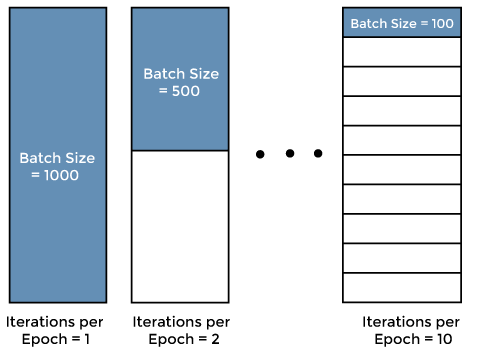

***Applying MinMax Scaler to each Image to transform image values from 0-255 ==> 0-1 Range***

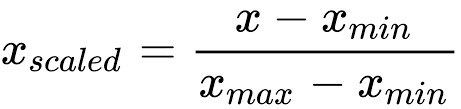

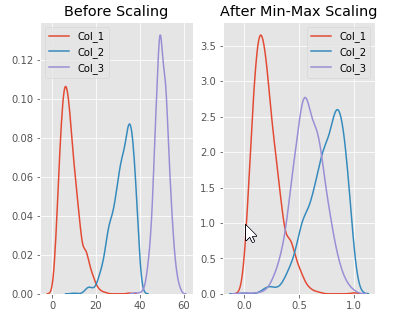

***Also Applying One Hot Encoding to each Ground Truth***

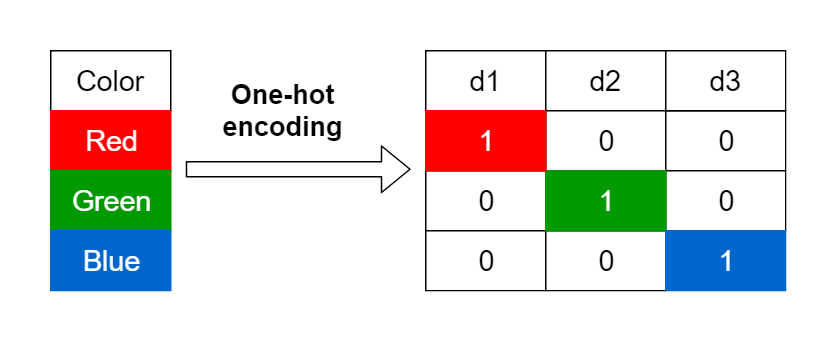

In [ ]:

import os
#import numpy as np
import tensorflow
from tensorflow.keras.utils import to_categorical


def load_img(images_directory, images_list):

    images=[]
    ground_truth_list = []

    for i, image_name in enumerate(images_list):

        if (image_name.split('.')[1] == 'npz'):

            image_file_path = os.path.join(images_directory,image_name)  #folder_name\ + image1.npz =  folder_name\image1.npz ==> complete address

            image_file = np.load(image_file_path)

            image = image_file["a"] #  a -> image --> UNET --> b gt


            # Appying MinMax Scaler to normalize the images values from 0-255 to 0-1 range

            #image = scaler.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape)

            image_ground_truth = image_file['b']

            n_classes = len(np.unique(image_ground_truth))

            #n_classes = 5
                                                                                    #[0.2, 0.6, 0.3, 0.8, 0.1]

            # transforming image groun truth to one hot encoded values i.e    0 ==> [1,0,0,0,0], 1 ==> [0,1,0,0,0], 2 ==> [0,0,1,0,0], 3 ==> [0,0,0,1,0], 4 = [0,0,0,0,1]

            # New Dimension of GroundTruth will be  (1088 x 1920) ==> (1088 x 1920 x 5 classes)

            #image_ground_truth = to_categorical(image_ground_truth, num_classes=n_classes)


            images.append(image)
            ground_truth_list.append(image_ground_truth)

            pass

        pass


    images = np.array(images)
    ground_truth_list = np.array(ground_truth_list)

    return(images,ground_truth_list)

################## Main Image Data Generator function to return new batch each time

def imageLoader(images_directory, images_list, batch_size):
  L = len(images_list)

  #keras needs the generator infinite, so we will use while true
  while True:

      batch_start = 0
      batch_end = batch_size # batch size = 2 (1088 x 1920 x 4)

      while batch_start < L:
          limit = min(batch_end, L)

          X , Y = load_img(images_directory, images_list[batch_start:limit]) # 0+2:2+2 --> 2:4 --> 4:6 --> 6:8

          # using yield instead of return to output the new batch after every function call (save the previous batch sequence)
          yield (X,Y) #a tuple with two numpy arrays with batch_size samples

          batch_start += batch_size
          batch_end += batch_size

          pass
      pass

In [2]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


# ***TRAINING***

### ***Loading Batch 1 for visualization.***

In [ ]:
npz_files_folder_path = '/content/drive/MyDrive/dataset/normalized_dataset/validation/'

#print(os.listdir(npz_files_folder_path))

npz_list = os.listdir(npz_files_folder_path)

# Taking Batch size of images per batch

batch_size = 1


images_dataGenerator = imageLoader(images_directory=npz_files_folder_path, images_list=npz_list, batch_size=batch_size)


X, Y = images_dataGenerator.__next__()

### ***Visualizing Image all channels with Ground truth***

-----

-----


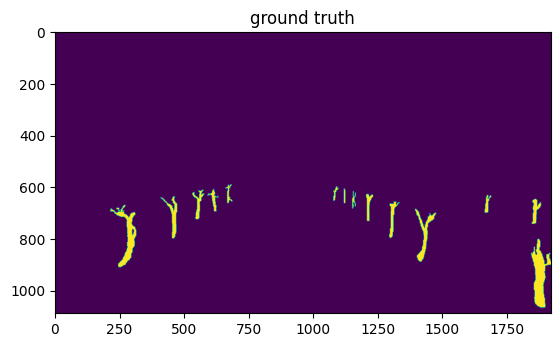

In [ ]:
# change image number to select image in batch

image_number = 0

image = X[image_number]

ground_truth = Y[image_number]



print("-----")


ground_truth = np.argmax(ground_truth, axis=2)

print()

print("-----")

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(image[:,:,0], cmap='gray')
plt.title('Blue')

plt.subplot(232)
plt.imshow(image[:,:,1], cmap='gray')
plt.title('Green')

plt.subplot(233)
plt.imshow(image[:,:,2], cmap='gray')
plt.title('Red')

plt.subplot(234)
plt.imshow(image[:,:,3], cmap='gray')
plt.title('Depth')



plt.subplot(235)
plt.imshow(ground_truth[:,:])
plt.title('ground truth')

plt.show()


### ***Importing Important Modules of Keras Framework***

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.layers import Activation,add
#from keras import backend as K

### ***UNET Architecture***

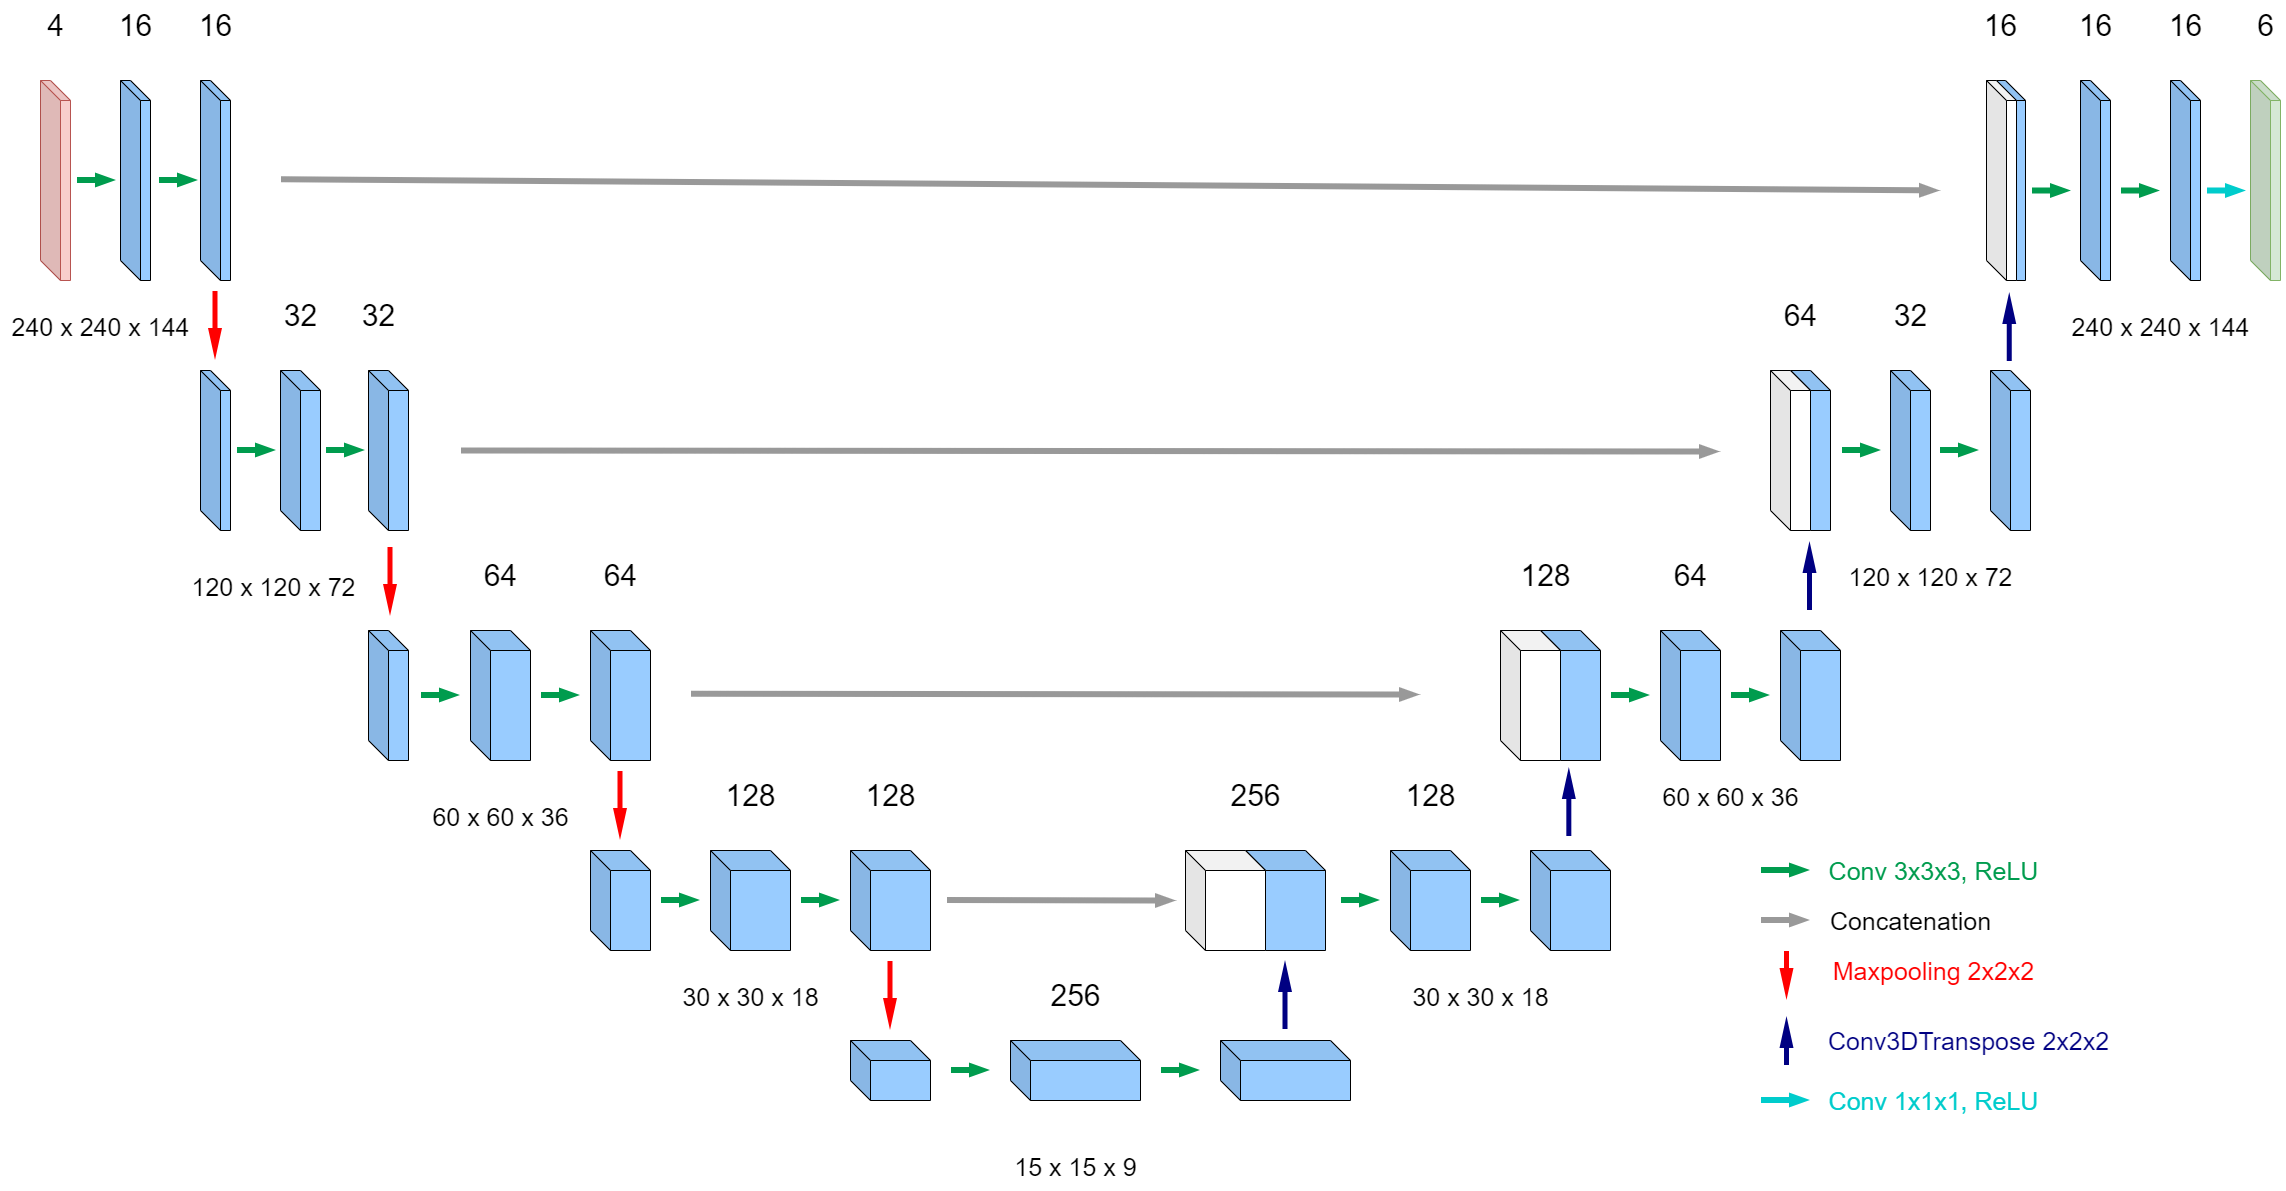

In [ ]:
def unet_model(num_classes=5, IMG_HEIGHT=1088, IMG_WIDTH=1920, IMG_CHANNELS=4):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    #model.summary()

    return model

### ***Custom Architecture Model***

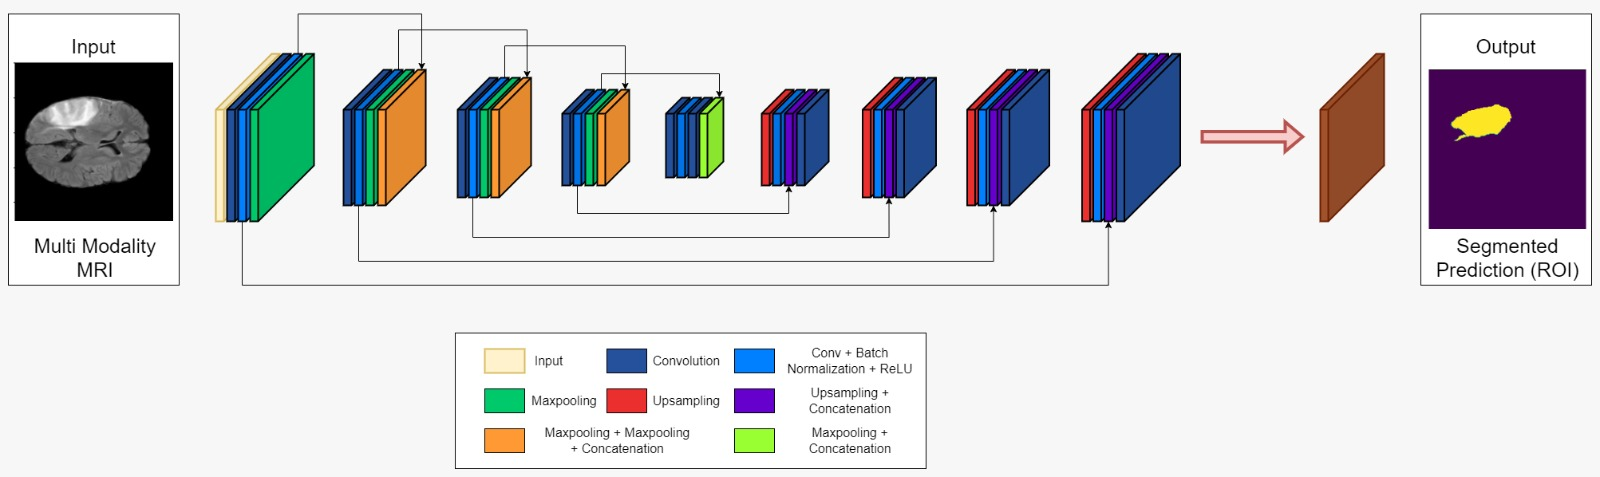

In [ ]:
################################################################
def custom_model(n_classes=5, IMG_HEIGHT=1088, IMG_WIDTH=1920, IMG_CHANNELS=4):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    s = inputs

    # Contraction path ----------------------------------------- ENCODER -------------------------------------------------

    # ---------------------------------------------------------- Level 1 ----------------------------------------------------------



    conv_1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)

    conv_1 = Conv2D(16, (3, 3), padding="same", kernel_initializer='he_normal')(conv_1)
    BN_1 = BatchNormalization()(conv_1)
    BN_1 = Activation("relu")(BN_1)

    pool_1 = MaxPooling2D(pool_size=(2, 2))(BN_1)

    # ---------------------------------------------------------- Level 2 ----------------------------------------------------------

    conv_2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_1)

    conv_2 = Conv2D(32, (3, 3), padding="same", kernel_initializer='he_normal')(conv_2)
    BN_2 = BatchNormalization()(conv_2)
    BN_2 = Activation("relu")(BN_2)

    pool_2 = MaxPooling2D(pool_size=(2, 2))(BN_2)

    # ----------------------------- concatination (Skip connection between level 1 and level 2) ------------------------------------

    concat_1 = MaxPooling2D(pool_size=(2, 2))(BN_1)
    concat_1 = MaxPooling2D(pool_size=(2, 2))(concat_1)

    concat_1 = concatenate([pool_2,concat_1])



    # ---------------------------------------------------------- Level 3 ----------------------------------------------------------


    conv_3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat_1)

    conv_3 = Conv2D(64, (3, 3), padding="same", kernel_initializer='he_normal')(conv_3)
    BN_3 = BatchNormalization()(conv_3)
    BN_3 = Activation("relu")(BN_3)

    pool_3 = MaxPooling2D(pool_size=(2, 2))(BN_3)


    #  ------------------------------------ concatination (Skip connection between level 2 and level 3) ------------------------------------

    concat_2 = MaxPooling2D(pool_size=(2, 2))(BN_2)
    concat_2 = MaxPooling2D(pool_size=(2, 2))(concat_2)

    concat_2 = concatenate([pool_3,concat_2])



    # ---------------------------------------------------------- Level 4 ----------------------------------------------------------


    conv_4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat_2)

    conv_4 = Conv2D(128, (3, 3), padding="same", kernel_initializer='he_normal')(conv_4)
    BN_4 = BatchNormalization()(conv_4)
    BN_4 = Activation("relu")(BN_4)

    pool_4 = MaxPooling2D(pool_size=(2, 2))(BN_4)


    #  ------------------------------------ concatination (Skip connection between level 3 and level 4)  ------------------------------------

    concat_3 = MaxPooling2D(pool_size=(2, 2))(BN_3)
    concat_3 = MaxPooling2D(pool_size=(2, 2))(concat_3)

    concat_3 = concatenate([pool_4,concat_3])


    # ---------------------------------------------------------- Bridge ----------------------------------------------------------


    conv_5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat_3)

    conv_5 = Conv2D(256, (3, 3), padding="same", kernel_initializer='he_normal')(conv_5)
    BN_5 = BatchNormalization()(conv_5)
    BN_5 = Activation("relu")(BN_5)

    conv_5 = Conv2D(256, (3, 3), activation='relu', padding="same", kernel_initializer='he_normal')(BN_5)


    #concatination

    concat_4 = MaxPooling2D(pool_size=(2, 2))(BN_4)

    concat_4 = concatenate([conv_5,concat_4])




    # Expansion path ----------------------------------------- DECODER -------------------------------------------------

    # ---------------------------------------------------------- Level 1 ----------------------------------------------------------

    upsamp_1 = UpSampling2D(size=(2,2))(concat_4)


    conv_6 = Conv2D(256, (3, 3), padding="same", kernel_initializer='he_normal')(upsamp_1)
    conv_6 = BatchNormalization()(conv_6)

    conv_6 = Activation("relu")(conv_6)


    #concatination

    concat_5 = concatenate([conv_6,BN_4])

    conv_6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat_5)


    # ---------------------------------------------------------- Level 2 ----------------------------------------------------------

    upsamp_2 = UpSampling2D(size=(2,2))(conv_6) #upsampling increases the size of feature maps 64x64 -> 128x128

    conv_7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upsamp_2)

    conv_7 = BatchNormalization()(conv_7)

    conv_7 = Activation("relu")(conv_7)


    #concatination

    concat_5 = concatenate([conv_7,BN_3])

    conv_7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat_5)



    # ---------------------------------------------------------- Level 3 ----------------------------------------------------------

    upsamp_3 = UpSampling2D(size=(2,2))(conv_7)

    conv_8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upsamp_3)

    conv_8 = BatchNormalization()(conv_8)

    conv_8 = Activation("relu")(conv_8)


    #concatination

    concat_6 = concatenate([conv_8,BN_2])

    conv_8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat_6)


    # ---------------------------------------------------------- Level 4 ----------------------------------------------------------

    upsamp_4 = UpSampling2D(size=(2,2))(conv_8)

    conv_9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upsamp_4)

    conv_9 = BatchNormalization()(conv_9)

    conv_9 = Activation("relu")(conv_9)


    #concatination

    concat_7 = concatenate([conv_9,BN_1])

    conv_9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat_7)


    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(conv_9)

    model = Model(inputs=[inputs], outputs=[outputs]) # 1088 x 1920 x 5 ( 5 predictions of 5 classes (stem, pole, rod, path, background) )


    return model

### ***Simple FCN architecture***

In [ ]:


def FCN(num_classes=5, IMG_HEIGHT=1088, IMG_WIDTH=1920, IMG_CHANNELS=4):

  inputs = keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

                                                  #ENCODER

  c1 = keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
  c1 = keras.layers.Dropout(0.1)(c1)
  c1 = keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
  p1 = keras.layers.MaxPooling2D((2, 2))(c1)

  c2 = keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
  c2 = keras.layers.Dropout(0.1)(c2)
  c2 = keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
  p2 = keras.layers.MaxPooling2D((2, 2))(c2)

  c3 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
  c3 = keras.layers.Dropout(0.2)(c3)
  c3 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
  p3 = keras.layers.MaxPooling2D((2, 2))(c3)

  c4 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
  c4 = keras.layers.Dropout(0.2)(c4)
  c4 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
  p4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

  c5 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
  c5 = keras.layers.Dropout(0.2)(c5)
  c5 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
  p5 = keras.layers.MaxPooling2D(pool_size=(2, 2))(c5)

  c6 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
  c6 = keras.layers.Dropout(0.3)(c6)
  c6 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

  u6 = keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
  c6 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
  c6 = keras.layers.Dropout(0.2)(c6)
  c6 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

                                                #DECODER

  u7 = keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
  c7 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
  c7 = tf.keras.layers.Add()([u7, c7])

  u8 = keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
  c8 = keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
  c8 = keras.layers.Add()([u8, c8])

  u9 = keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
  c9 = keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
  c9 = keras.layers.Add()([u9, c9])

  u10 = keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c9)
  c10 = keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
  c10 = keras.layers.Add()([u10, c10])

  outputs = keras.layers.Conv2D(num_classes, (1, 1), activation='softmax')(c10)

  model = keras.Model(inputs=[inputs], outputs=[outputs])

  return model
  pass

In [ ]:
model = FCN(num_classes=5, IMG_HEIGHT=1088, IMG_WIDTH=1920, IMG_CHANNELS=4)

print(model.summary())

### ***IMPORTING KERAS BACKEND FOR USING KERAS FUNCTIONS***

In [ ]:
from keras import backend as K

### ***DICE SIMILARITY COEFFICIENT***

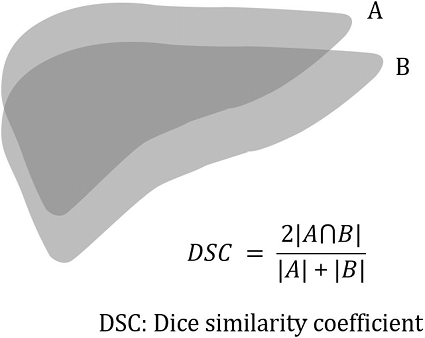

In [ ]:
smooth = 1.

def dice_similarity_coefficient(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_flatten * y_pred_flatten)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_flatten) + tf.reduce_sum(y_pred_flatten) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_similarity_coefficient(y_true, y_pred)

### ***JACCARD SIMILARITY COEFFICIENT***

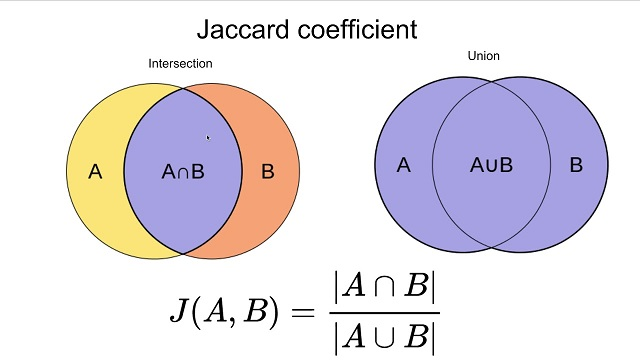

In [ ]:
def jaccard_similarity_coefficient(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    return (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)

### ***IOU score as Performance Evaluation metric for Segmentation Model***

In [ ]:
!pip install segmentation-models
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm

IOU_score = sm.metrics.IOUScore(threshold=0.5)

### ***Other Evaluation Metrics***

In [ ]:
import keras
from keras import backend as K

def recall_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



Specificity = keras.metrics.SpecificityAtSensitivity(0.5)

Sensitivity = keras.metrics.SensitivityAtSpecificity(0.5)

precision_metric = keras.metrics.Precision(thresholds=0)

### ***Hyperparameters***

***Loss Function (Categorical Cross-entropy)***

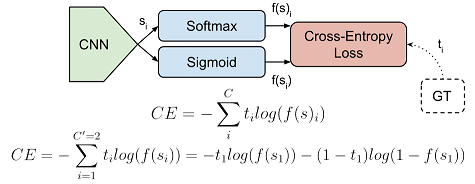

***Optimizer (Adam)***

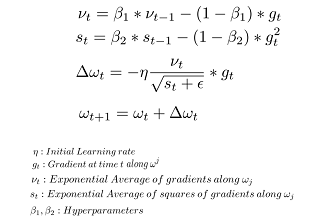

In [ ]:
import keras
import tensorflow as tf
import segmentation_models as sm

###########################################################################
#Define loss, metrics and optimizer to be used for training
wt0, wt1, wt2, wt3, wt4 = 0.20, 0.20, 0.20, 0.20, 0.20

from tensorflow.keras.metrics import MeanIoU

############################################# LOSS Functions

#dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3,wt4]))
dice_loss = sm.losses.DiceLoss(class_weights=[wt0, wt1, wt2, wt3,wt4])
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

crossentropy_loss = 'categorical_crossentropy'

selected_loss_function = focal_loss
############################################## Model performance evaluation metrices

metrics = ['accuracy',IOU_score,jaccard_similarity_coefficient,dice_similarity_coefficient,recall_score,precision_score,f1_score,Specificity,Sensitivity]


############################################## Optimizer (Learning Algorithm)

#Learning_Rate = 0.0001
Learning_Rate = 0.001 # 4 5  bigger smaller its global adaptive
optimizer = tf.keras.optimizers.Adam(Learning_Rate)
#######################################################################


############################################## defining batch size

batch_size = 2

############################################## defining training steps on each epoch

training_images_directory = '/content/drive/MyDrive/dataset/normalized_dataset/train/'

training_images_names_list = os.listdir(training_images_directory)            # List of training images


validation_images_directory = '/content/drive/MyDrive/dataset/normalized_dataset/validation/'

validation_images_names_list = os.listdir(validation_images_directory)        # List of validation images


steps_per_epoch = len(training_images_names_list)//batch_size                 # steps = number-of-images/batchs-size = 80/20 = 4
validation_steps_per_epoch = len(validation_images_names_list)//batch_size    # steps =                       20/20 = 1


############################################## Number of epochs

number_of_epochs = 50



### ***Importing CallBacks function to frequently saving the training of Architecture (UNET)***

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

# Model Callbacks functions

##########################################################################################

"""model_file_path = '/content/drive/MyDrive/dataset/training history/unet_model.hdf5'

csv_file_path = '/content/drive/MyDrive/dataset/training history/unet_model_history.csv'"""


model_file_path = '/content/drive/MyDrive/dataset/training history/focal_loss_custom_model.hdf5'

csv_file_path = '/content/drive/MyDrive/dataset/training history/focal_loss_custom_model_history.csv'


history_logger = tf.keras.callbacks.CSVLogger(filename=csv_file_path,separator=",",append=True)

checkpoint = ModelCheckpoint(model_file_path, monitor="val_loss", save_best_only=False, verbose=2)

##########################################################################################

### ***Getting list of training and validation images addresses***

In [ ]:
training_images_directory = '/content/drive/MyDrive/dataset/normalized_dataset/train/'

training_images_names = os.listdir(training_images_directory)


validation_images_directory = '/content/drive/MyDrive/dataset/normalized_dataset/validation/'

validation_images_names = os.listdir(validation_images_directory)


print("Training images :",len(training_images_names))
print("Validation Images :",len(validation_images_names))

#

training_images_names_list = training_images_names
validation_images_names_list = validation_images_names


Training images : 80
Validation Images : 20


### ***Calling Image Data generator for Both training and validation set for creating batches***

In [ ]:
# defining batch size for both training and validation set


training_set_batch_size =  batch_size

validation_set_batch_size = batch_size

############################################## Calling Image data generators

train_image_data_generator = imageLoader(images_directory=training_images_directory, images_list=training_images_names_list, batch_size=batch_size)


validation_image_data_generator = imageLoader(images_directory=validation_images_directory, images_list=validation_images_names_list, batch_size=batch_size)


### ***DEFINING UNET ARCHITECTURE***

In [ ]:
############################################## initializing UNET MODEL
model = unet_model(IMG_HEIGHT=1088,
                          IMG_WIDTH=1920,
                          IMG_CHANNELS=4,
                          num_classes=5)

print(model.summary())

### ***Custom Architecture***

In [ ]:
model = custom_model(n_classes=5, IMG_HEIGHT=1088, IMG_WIDTH=1920, IMG_CHANNELS=4)

print(model.summary())

### ***FCN Architecture***

In [ ]:
model = FCN(num_classes=5, IMG_HEIGHT=1088, IMG_WIDTH=1920, IMG_CHANNELS=4)

#print(model.summary())

### ***Compiling Model***

In [ ]:
############################################# Compiling Model

model.compile(optimizer = optimizer, loss=focal_loss, metrics=metrics)

In [ ]:
from keras.models import load_model
############################################## Loading previously trained UNET MODEL
#path = '/content/drive/MyDrive/dataset/training history/unet_model.hdf5'

path = '/content/drive/MyDrive/dataset/training history/focal_loss_custom_model.hdf5'

model = load_model(path,custom_objects={'iou_score':IOU_score,
                                        'jaccard_similarity_coefficient':jaccard_similarity_coefficient,
                                        'dice_similarity_coefficient':dice_similarity_coefficient,
                                        'recall_score':recall_score,'precision_score':precision_score,
                                         'f1_score':f1_score,'Specificity':Specificity,
                                          'Sensitivity':Sensitivity,'focal_loss': focal_loss})

#'dice_loss_plus_1focal_loss': total_loss

In [ ]:
history=model.fit(train_image_data_generator,
          steps_per_epoch=steps_per_epoch,
          epochs=number_of_epochs,
          callbacks=[[history_logger],[checkpoint]],
          verbose=1,
          validation_data=validation_image_data_generator,
          validation_steps=validation_steps_per_epoch,
          )


#model.save('/content/drive/MyDrive/dataset/training history/unet_model.hdf5')
model.save('/content/drive/MyDrive/dataset/training history/focal_loss_custom_model.hdf5')

### ***Inference (Prediction)***

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
from keras.models import load_model

***Loading UNET***

In [ ]:
UNET = load_model('/content/drive/MyDrive/dataset/training history/unet_model.hdf5',
                      compile=False)

***Loading Custom Architecture***

In [ ]:
Custom_model = load_model('/content/drive/MyDrive/dataset/training history/custom_model.hdf5',
                      compile=False)

***FCN Architecture***

In [ ]:
FCN = load_model('/content/drive/MyDrive/dataset/training history/FCN_model.hdf5',
                      compile=False)

In [ ]:
model = load_model('/content/drive/MyDrive/dataset/training history/crossentropy_custom_model.hdf5',
                      compile=False)

In [ ]:
#change model name here

#model = UNET
model = Custom_model
#model = FCN

***Using Image data generator to load image batches for prediction/inference***

In [ ]:
npz_files_folder_path = '/content/drive/MyDrive/dataset/normalized_dataset/validation/'


npz_list = os.listdir(npz_files_folder_path)

# Taking Batch size of images per batch

batch_size = 1


images_dataGenerator = imageLoader(images_directory=npz_files_folder_path, images_list=npz_list, batch_size=batch_size)

In [ ]:
#use this function to load next image every time

X, Y = images_dataGenerator.__next__()


1/1 [==============================] - 15s 15s/step
(1, 1088, 1920, 5)


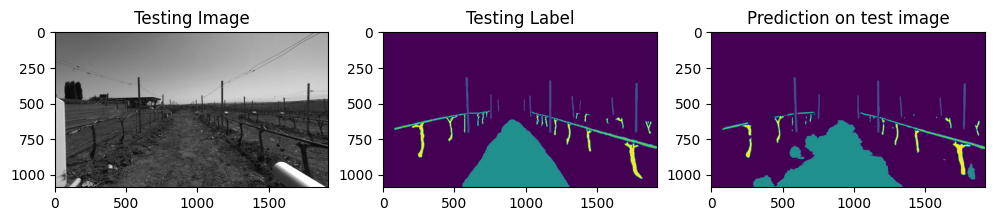

In [ ]:
prediction = model.predict(X)

ground_truth = Y[0]

final_ground_truth = np.argmax(ground_truth,axis=2)

print(prediction.shape)

final_prediction = np.argmax(prediction,axis=3)[0,:,:]


new_image = X[0]

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(new_image[:,:,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(final_ground_truth[:,:])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(final_prediction[:,:])
plt.show()

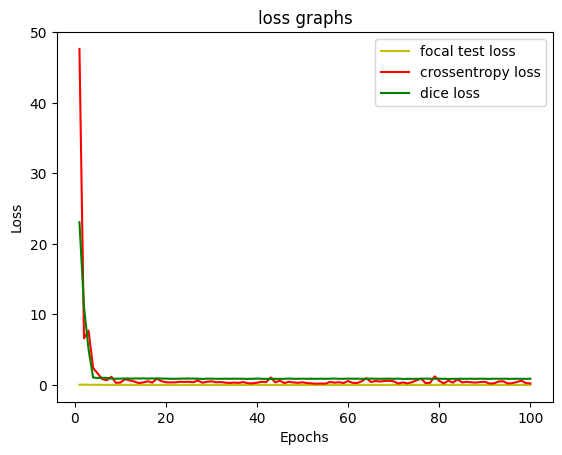

In [10]:
import pandas as pd
focal_csv_file_path = "/content/drive/MyDrive/dataset/training history/focal_loss_custom_model_history.csv"
crossentropy_csv_file_path = "/content/drive/MyDrive/dataset/training history/crossentropy_custom_model_history.csv"
dice_csv_file_path = "/content/drive/MyDrive/dataset/training history/dice_loss_custom_model_history.csv"


focal_history_dataframe = pd.read_csv(focal_csv_file_path)
crossentropy_history_dataframe = pd.read_csv(crossentropy_csv_file_path)
dice_history_dataframe = pd.read_csv(dice_csv_file_path)


##################################################################


#plot the training and validation IoU and loss at each epoch
focal_loss = np.array(focal_history_dataframe['val_loss'])
crossentropy_loss = np.array(crossentropy_history_dataframe['val_loss'])
dice_loss = np.array(dice_history_dataframe['val_loss'])

epochs = range(1, len(crossentropy_loss) + 1)
plt.plot(epochs, focal_loss, 'y', label='focal test loss')
plt.plot(epochs, crossentropy_loss, 'r', label='crossentropy loss')
plt.plot(epochs, dice_loss, 'g', label='dice loss')

plt.title('loss graphs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



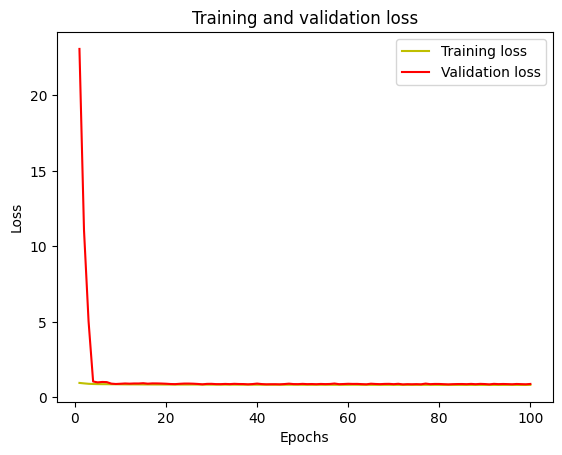

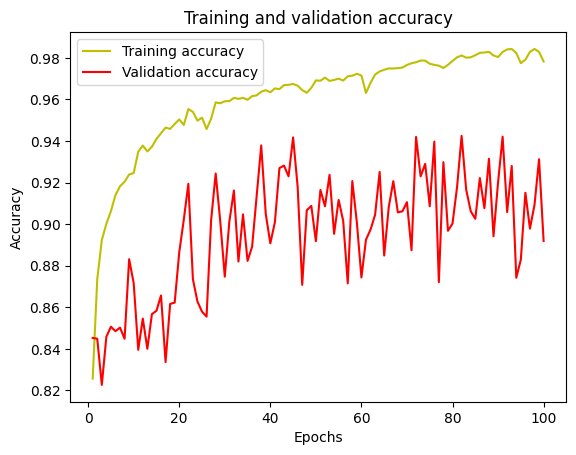

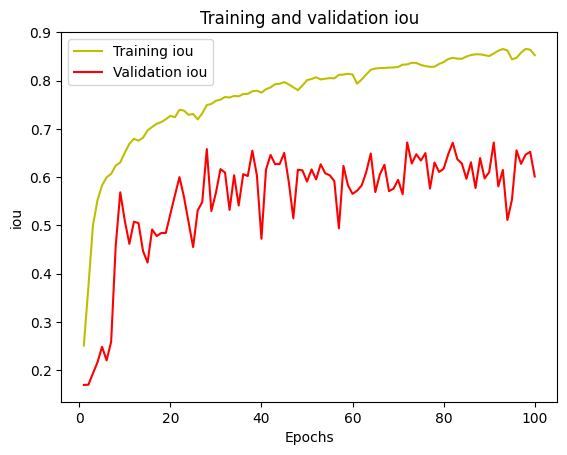

Epoches :  100


In [22]:
import pandas as pd
csv_file_path = "/content/drive/MyDrive/dataset/training history/dice_loss_custom_model_history.csv"

training_history_dataframe = pd.read_csv(csv_file_path)


##################################################################


#plot the training and validation IoU and loss at each epoch
loss = np.array(training_history_dataframe['loss'])
val_loss = np.array(training_history_dataframe['val_loss'])
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = np.array(training_history_dataframe['accuracy'])
val_acc = np.array(training_history_dataframe['val_accuracy'])

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

iou = np.array(training_history_dataframe['iou_score'])
val_iou = np.array(training_history_dataframe['val_iou_score'])

plt.plot(epochs, iou, 'y', label='Training iou')
plt.plot(epochs, val_iou, 'r', label='Validation iou')
plt.title('Training and validation iou')
plt.xlabel('Epochs')
plt.ylabel('iou')
plt.legend()
plt.show()


print("Epoches : ",len(epochs))
#################################################

In [ ]:
crossentropy_history_dataframe.iloc[62,:]['val_loss'] = 0.52

print(crossentropy_history_dataframe.iloc[62,:]['val_loss'])

0.5219472


<ipython-input-24-f6582ec04cc9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crossentropy_history_dataframe.iloc[62,:]['val_loss'] = 0.52


In [ ]:
"""del model
del prediction
del final_ground_truth
del final_prediction
del new_image"""

del X1, Y1